In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [64]:
df = pd.read_excel('12monthsnew data.xls',sheetname='data to use',index_col='Date')

In [65]:
df = df.dropna()

In [68]:
df_forecast = df.loc['20090101':'20091231',:]

In [69]:
df = df.loc['20070101':'20081231',:]

In [70]:
df.to_excel('Results/in-sample.xls')

In [59]:
len(df_forecast)

253

Stationary Check

In [25]:
import math
max_lag = math.floor(len(df)**1/3)

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series,maxlag=max_lag)
    string = ""
    string += 'Augmented Dickey-Fuller Test:\n'
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        string += label+' : '+str(value)+'\n'
    
    if result[1] <= 0.05:
        string += "strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary"
    else:
        string += "weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary "
        
    print(string)
    with open("Results/ADF-0709.txt", "w") as text_file:
        print(string, file=text_file)

In [28]:
adf_check(df['Return'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.12376401418
p-value : 3.66507412028e-10
#Lags Used : 5
Number of Observations Used : 501
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


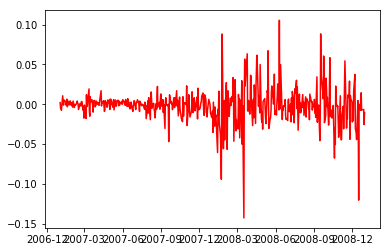

In [9]:
plt.plot(df['Return'],'r')
plt.savefig('Results/plot-0709.png',dpi=2000)

Autocorrelation

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

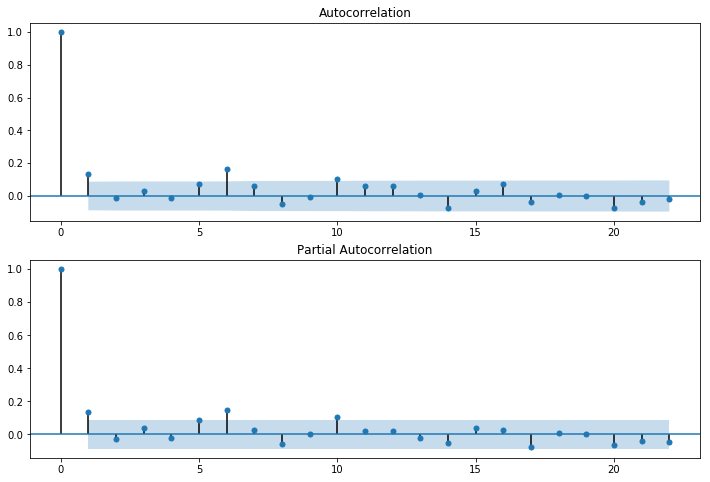

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Return'].dropna(),lags=22,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Return'].dropna(),lags=22,ax=ax2)
fig.savefig('Results/acf22-0709.png',dpi=2000)

ARMA

In [31]:
p_max=7
q_max=7

In [32]:
p_list = []
q_list = []
AIC_list = []
BIC_list = []

In [33]:
minAIC = 0
minBIC = 0
pminAIC = 0
pminBIC = 0
qminAIC = 0
qminBIC = 0

In [34]:
#warnings.filterwarnings('ignore')
for p in range (0,p_max):
    for q in range (0,q_max):
        try:
            model = sm.tsa.ARMA(df['Return'],order=(p,q))
            results = model.fit(maxiter=1000)
            p_list.append(p)
            q_list.append(q)
            AIC_list.append(results.aic)
            BIC_list.append(results.bic)
            if minAIC>results.aic:
                minAIC = results.aic
                pminAIC = p
                qminAIC = q
            if minBIC>results.bic:
                minBIC = results.bic
                pminBIC = p
                qminBIC = q
        except:
            continue

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [35]:
results = {'p':p_list,'q':q_list,'AIC':AIC_list,'BIC':BIC_list}

In [36]:
models = pd.DataFrame(data=results)

In [37]:
models['AIC'] = models['AIC']/len(df)

In [38]:
models['BIC'] = models['BIC']/len(df)

In [39]:
models.to_excel('Results/models0709.xls')

In [40]:
Str_conclusion = 'According to AIC, the minimum AIC value is '+str(minAIC)+' at p='+str(pminAIC)+' and q='+str(qminAIC)+'.\n'+'According to BIC, the minimum BIC value is '+str(minBIC)+' at p='+str(pminBIC)+' and q='+str(qminBIC)+'.\n'
with open("Results/ARMA_chosen_model(07-09).txt", "w") as text_file:
        print(Str_conclusion, file=text_file)
Str_conclusion

'According to AIC, the minimum AIC value is -2477.387650722595 at p=6 and q=6.\nAccording to BIC, the minimum BIC value is -2454.40352256 at p=0 and q=1.\n'

Model statistics

In [42]:
model = sm.tsa.ARMA(df['Return'],order=(pminBIC,qminBIC))
res = model.fit(maxiter=1000)

Str_conclusion = str(res.summary())
with open("Results/ARMA_summary.txt", "w") as text_file:
        print(Str_conclusion, file=text_file)
Str_conclusion

'                              ARMA Model Results                              \n==============================================================================\nDep. Variable:                 Return   No. Observations:                  507\nModel:                     ARMA(0, 1)   Log Likelihood                1236.545\nMethod:                       css-mle   S.D. of innovations              0.021\nDate:                Wed, 27 Dec 2017   AIC                          -2467.089\nTime:                        17:10:33   BIC                          -2454.404\nSample:                    01-02-2007   HQIC                         -2462.114\n                         - 12-31-2008                                         \n================================================================================\n                   coef    std err          z      P>|z|      [0.025      0.975]\n--------------------------------------------------------------------------------\nconst           -0.0019      0.00

Model Diagnostic



In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox as LB

In [37]:
result = [pd.Series(range(1,11)),pd.Series(LB(res.resid,lags=10)[0])]
Lbt = pd.concat(result,axis=1)
Lbt.columns=['lags','Test Result']

In [38]:
Lbt.to_excel('Results/Ljung-Box Test.xls')

In [39]:
from statsmodels.stats.stattools import jarque_bera as JB

In [40]:
result = JB(res.resid)
JBResult = 'Jarque-Bera: '+ str(result[0])+'\n p-value:' + str(result[1])+'\n Skewness:' + str(result[2])+'\n Kurtosis:' + str(result[3])
with open("Results/Jarque-Bera.txt", "w") as text_file:
        print(JBResult, file=text_file)

Forecast

Use p=0, q=1

In [43]:
first_day = 0
forecast_day = len(df)
forecast = []
df = df.append(df_forecast)
last_day = len(df_forecast)

In [44]:
for i in range(0,last_day):
    in_sample = df.iloc[first_day:forecast_day-1]
    model = sm.tsa.ARMA(in_sample['Return'],order=(0,1))
    res = model.fit(maxiter=1000)
    fore = res.forecast(1)[0][0]
    forecast.append(fore)
    first_day = first_day+1
    forecast_day = forecast_day+1

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [45]:
forecast_data = pd.Series(data=forecast,index=df_forecast.index)
df_forecast = pd.concat([df_forecast,forecast_data],axis=1)

In [46]:
df_forecast.columns=['Rate','Return','Forecast log']

In [48]:
df_forecast['Forecast ARMA'] = np.exp(df_forecast['Forecast log'])*df_forecast['Rate'].shift(1)
df_forecast['Forecast ARMA'].iloc[0] = np.exp(df_forecast['Forecast log'].iloc[0])*df['Rate'].iloc[-1]
MAE_ARMA = np.average(np.abs(df_forecast['Rate']-df_forecast['Forecast ARMA']))
Sum_Square = (df_forecast['Rate']-df_forecast['Forecast ARMA'])**2
RMSE_ARMA = np.sqrt(np.average(Sum_Square))

In [49]:
df_forecast['Naive'] = df_forecast['Rate'].shift(1)
df_forecast['Naive'].iloc[0] = df['Rate'].iloc[-1]
MAE_naive = np.average(np.abs(df_forecast['Rate']-df_forecast['Naive']))
Sum_Square_naive = (df_forecast['Rate']-df_forecast['Naive'])**2
RMSE_naive = np.sqrt(np.average(Sum_Square_naive))

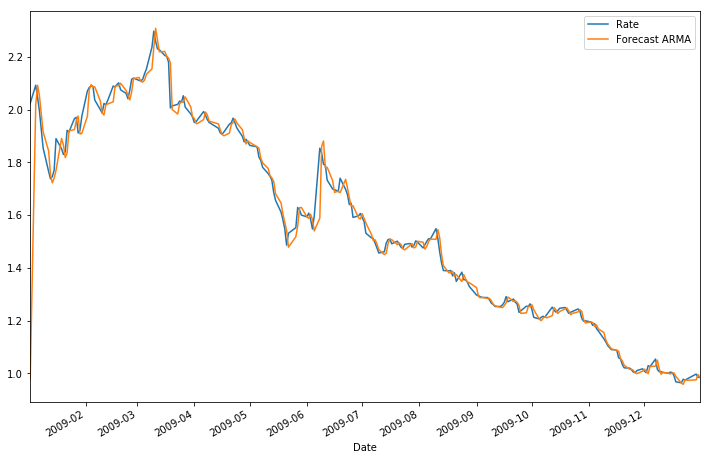

In [50]:
df_forecast[['Rate','Forecast ARMA']].plot(figsize=(12,8))

<h1>ARMA-GARCH

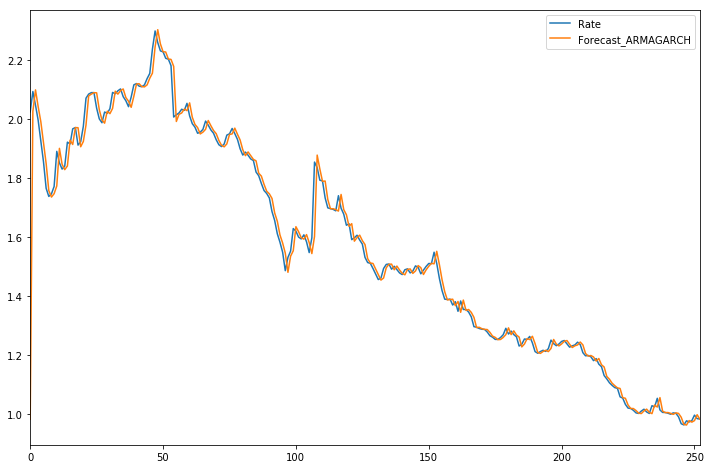

In [53]:
df_armagarch = pd.read_excel('Results\Forecast.xls',index_col='Date')
df_armagarch['Forecast_ARMAGARCH'] = np.exp(df_armagarch['Forecast'])*df_armagarch['Rate'].shift(1)
df_armagarch['Forecast_ARMAGARCH'].iloc[0] = np.exp(df_armagarch['Forecast'].iloc[0])*df['Rate'].iloc[-1]
df_forecast = df_forecast.merge(pd.DataFrame(df_armagarch),how='left')
df_forecast.drop('Forecast',axis=1,inplace=True)
df_forecast.drop('Residuals',axis=1,inplace=True)
df_forecast.to_excel('Results/Prediction 2009 (model 2007-2008).xls')
MAE_ag = np.average(np.abs(df_forecast['Rate']-df_forecast['Forecast_ARMAGARCH']))
Sum_Square_ag = (df_forecast['Rate']-df_forecast['Forecast_ARMAGARCH'])**2
RMSE_ag = np.sqrt(np.average(Sum_Square_ag))
df_forecast[['Rate','Forecast_ARMAGARCH']].plot(figsize=(12,8))

Forecast Results

In [54]:
title = ['Naive','ARMA','ARMA-Garch']
obs = [str(len(df_forecast)),str(len(df_forecast)),str(len(df_forecast))]
no1 = [RMSE_naive,RMSE_ARMA,RMSE_ag]
no2 = [MAE_naive,MAE_ARMA,MAE_ag]
result = pd.DataFrame(np.transpose([obs,no1,no2]),index=title,columns=['Number of Observations','RMSE','MAE'])
result.to_excel('Results/Forecast_Result.xls')